In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import ParameterGrid

In [2]:
# Configurações
DATA_DIR = "PokemonData"  # Substitua pelo caminho da sua pasta
IMG_SIZE = 120
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
NUM_WORKERS = 4 if os.name != 'nt' else 0  # Evitar problemas no Windows

In [3]:
# Verificar se a GPU está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")

Usando: cuda


In [4]:
# Transformações
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalização do ImageNet
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Carregar dataset
train_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transform
)

# Verificar classes
classes = train_dataset.classes
print(f"Número de classes: {len(classes)}")
print(f"Classes: {classes}")

# Dividir o dataset em treino e validação
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Criar DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

Número de classes: 150
Classes: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 

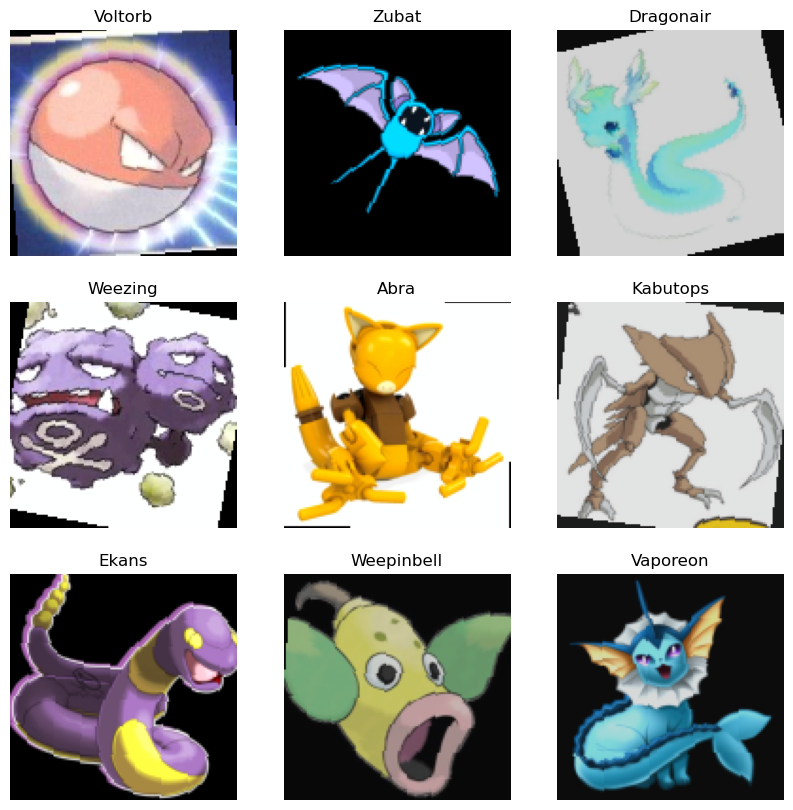

In [6]:
# Visualizar algumas imagens
def show_images(images, labels, classes):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Desnormalizar
        plt.imshow(img.clip(0, 1))
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()
    
# Obter um batch de imagens
images, labels = next(iter(train_loader))
show_images(images, labels, classes)

In [7]:
# Definir a CNN
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super(PokemonCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Camada 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Camada 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Camada 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # Inicialização Xavier
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [8]:
# Função para treinar e avaliar o modelo
def train_and_evaluate(model, train_loader, val_loader, learning_rate, weight_decay, num_epochs):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
    
    return accuracy, train_losses, val_accuracies

In [9]:
# Grid Search Manual
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'num_epochs': [100],
    'weight_decay': [0.00001]
}

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Testando parâmetros: {params}")
    train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False, num_workers=NUM_WORKERS)
    model = PokemonCNN(num_classes=len(classes)).to(device)
    accuracy, train_losses, val_accuracies = train_and_evaluate(model, train_loader, val_loader, learning_rate=params['learning_rate'], weight_decay=params['weight_decay'], num_epochs=params['num_epochs'])
    print(f"Acurácia: {accuracy:.2f}%")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_train_losses = train_losses
        best_val_accuracies = val_accuracies

print(f"Melhores parâmetros: {best_params}")
print(f"Melhor acurácia: {best_accuracy:.2f}%")

Testando parâmetros: {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 100, 'weight_decay': 1e-05}
Acurácia: 73.02%
Testando parâmetros: {'batch_size': 32, 'learning_rate': 0.0001, 'num_epochs': 100, 'weight_decay': 1e-05}
Acurácia: 71.99%
Testando parâmetros: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 100, 'weight_decay': 1e-05}
Acurácia: 74.63%
Testando parâmetros: {'batch_size': 64, 'learning_rate': 0.0001, 'num_epochs': 100, 'weight_decay': 1e-05}
Acurácia: 70.67%
Melhores parâmetros: {'batch_size': 64, 'learning_rate': 0.001, 'num_epochs': 100, 'weight_decay': 1e-05}
Melhor acurácia: 74.63%


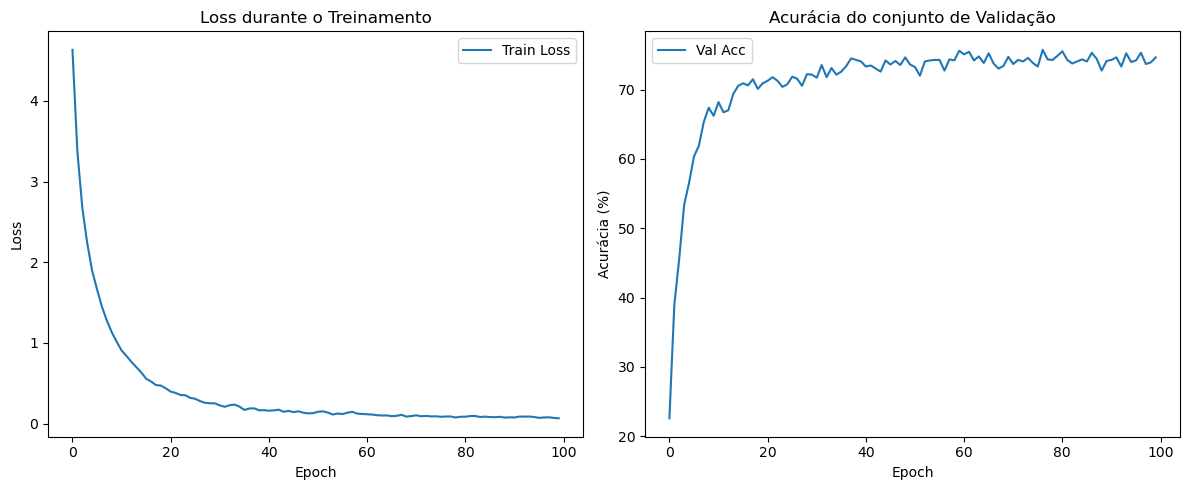

In [10]:
# Plotar métricas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss durante o Treinamento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia do conjunto de Validação')
plt.legend()

plt.tight_layout()
plt.show()